# Configuração do Ambiente

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)
plt.figure(figsize=(12, 8)) 
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

<Figure size 1200x800 with 0 Axes>

# Análise Exploratória de Dados

Os dados de trabalho foram obtidos do [Medical Insurance Cost with Linear Regression](https://www.kaggle.com/code/mariapushkareva/medical-insurance-cost-with-linear-regression/notebook)

In [2]:
file_name = "insurance.csv"
dataframe = pd.read_csv(file_name)
print('---------Informações sobre o DataFrame----------')
print(dataframe.info()) 
print('\n---------Primeiros Registros do DataFrame----------')
dataframe.head()

---------Informações sobre o DataFrame----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

---------Primeiros Registros do DataFrame----------


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
dataframe.groupby('region').count()

,age,sex,bmi,children,smoker,charges
region,,,,,,
northeast,324,324,324,324,324,324
northwest,325,325,325,325,325,325
southeast,364,364,364,364,364,364
southwest,325,325,325,325,325,325


A primira avaliação mostra que temos algumas colunas categóricas (sex, smoker,  region), que precisarão ser tratadas para que possamos fazer a regressão linear.

Outras colunas (age, bmi, children e charges) estão em escalas diferentes. Pode ser interessante aplicar feature scaling para uniformizar os dados para análise.

Temos 1338 entradas, sendo que não há nenhum registro nulo:

In [4]:
dataframe.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Não precisamos nos preocupar com o tratamento de registros nulos.

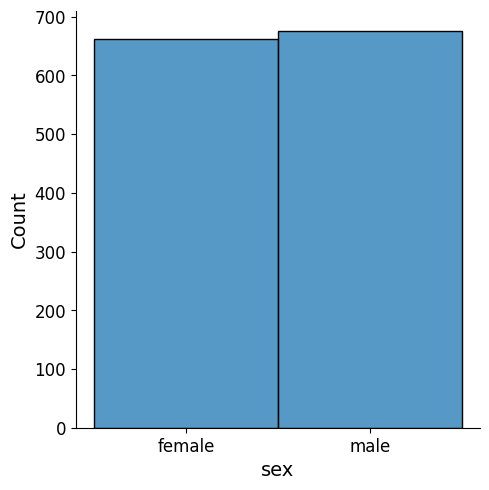

In [5]:
# A base está equilibrada entre as homens e mulheres?
sns.displot(data=dataframe["sex"])

In [6]:
dataframe.groupby("children")["charges"].count()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: charges, dtype: int64

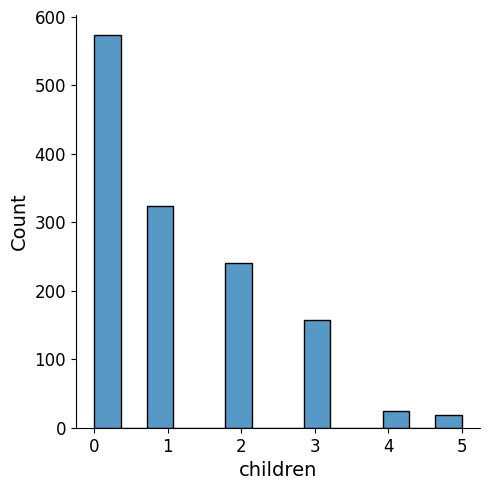

In [7]:
# A base está equilibrada entre as pessoas com nenhum, um ou mais de um filho?
sns.displot(data=dataframe["children"])

In [8]:
dataframe.groupby("smoker")["charges"].count()

smoker
no     1064
yes     274
Name: charges, dtype: int64

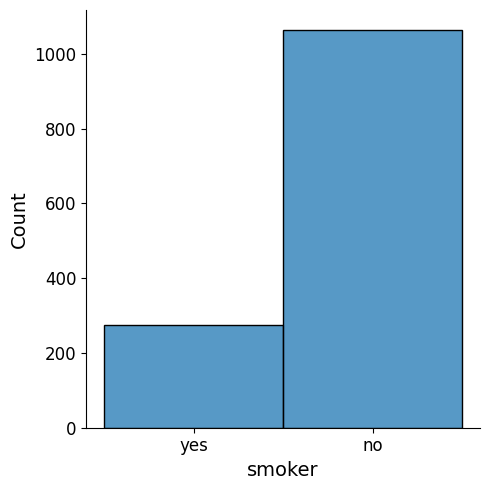

In [9]:
# A base está equilibrada entre fumantes e não fumantes?
sns.displot(data=dataframe["smoker"])

In [10]:
dataframe.groupby("region")["charges"].count()

region
northeast    324
northwest    325
southeast    364
southwest    325
Name: charges, dtype: int64

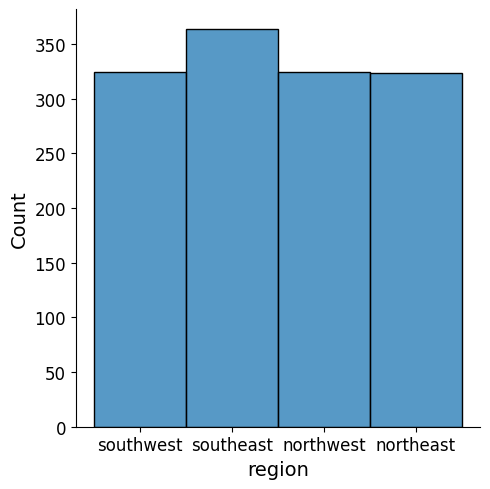

In [11]:
# A base está equilibrada entre as regiões?
sns.displot(data=dataframe["region"])

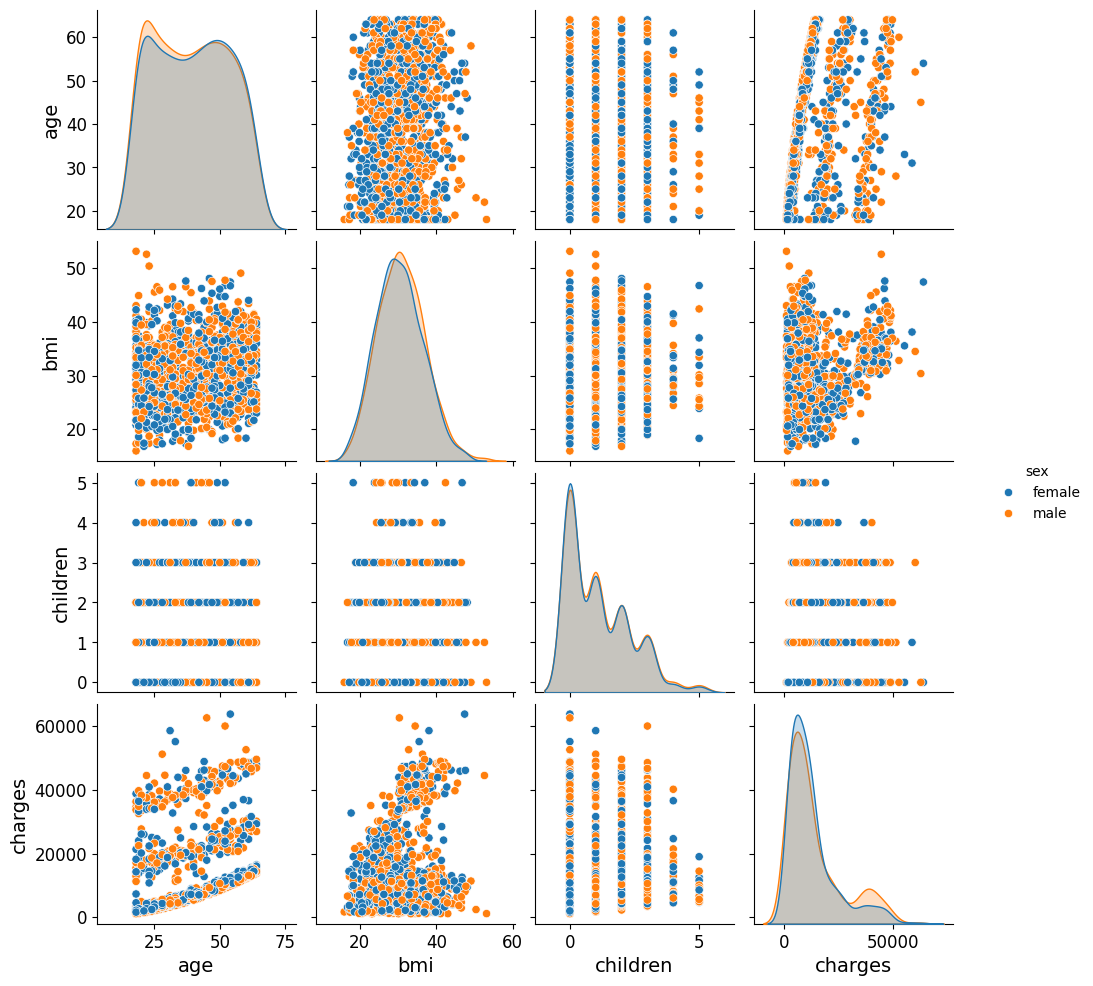

In [12]:
sns.pairplot(dataframe, hue='sex')

# Tratamento de Dados

Os tratamentos serão feitos em etapas, preservando cada transformação.

In [13]:
# Criando o dataframe que vai conter  as colunas categóricas
encoded_dataframe = dataframe.copy()

Tratando as colunas categoricas ('sex', 'smoker', 'region') para que sejam levadas em conta na regressão.

In [14]:
# Convertendo variáveis categóricas
encoded_dataframe['sex'] = encoded_dataframe['sex'].map({'female': 0, 'male': 1})
encoded_dataframe['smoker'] = encoded_dataframe['smoker'].map({'no': 0, 'yes': 1})

# Usando one-hot encoding para a coluna 'region'
region_dummies = pd.get_dummies(encoded_dataframe['region'])
encoded_dataframe = pd.concat([encoded_dataframe.drop('region', axis=1), region_dummies], axis=1)

encoded_dataframe.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


Realizando o Feature Scaling (das colunas numéricas ('age', 'bmi', 'children', 'charges') com MinMaxScaler.

In [15]:
# Min-Max Scaler
min_max_scaler = MinMaxScaler()

# Selecionar colunas numéricas
numerical_cols = ['age', 'bmi', 'children', 'charges']

# Criando o dataframe que vai conter as colunas tratadas com feature scaling
scaled_encoded_dataframe = encoded_dataframe.copy()

# Aplicando o Feature Scaling
scaled_encoded_dataframe[numerical_cols] = min_max_scaler.fit_transform(scaled_encoded_dataframe[numerical_cols])
scaled_encoded_dataframe.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,0.021739,0,0.321227,0.0,1,0.251611,False,False,False,True
1,0.000000,1,0.479150,0.2,0,0.009636,False,False,True,False
2,0.217391,1,0.458434,0.6,0,0.053115,False,False,True,False
3,0.326087,1,0.181464,0.0,0,0.333010,False,True,False,False
4,0.304348,1,0.347592,0.0,0,0.043816,False,True,False,False


<Axes: >

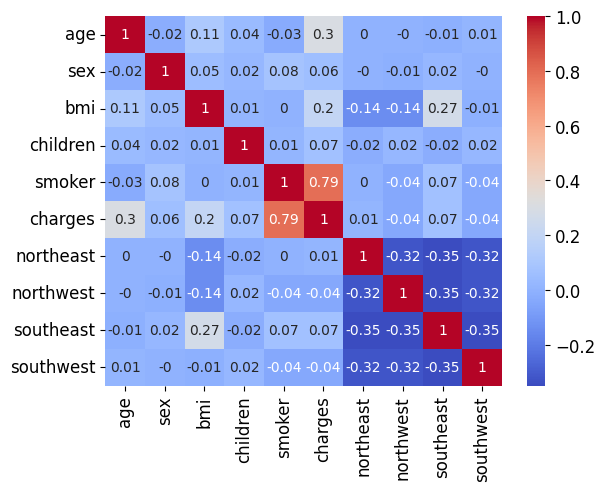

In [16]:
# Cria heatmap com o dataframe tratado
sns.heatmap(scaled_encoded_dataframe.corr().round(2), annot=True, cmap="coolwarm")

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

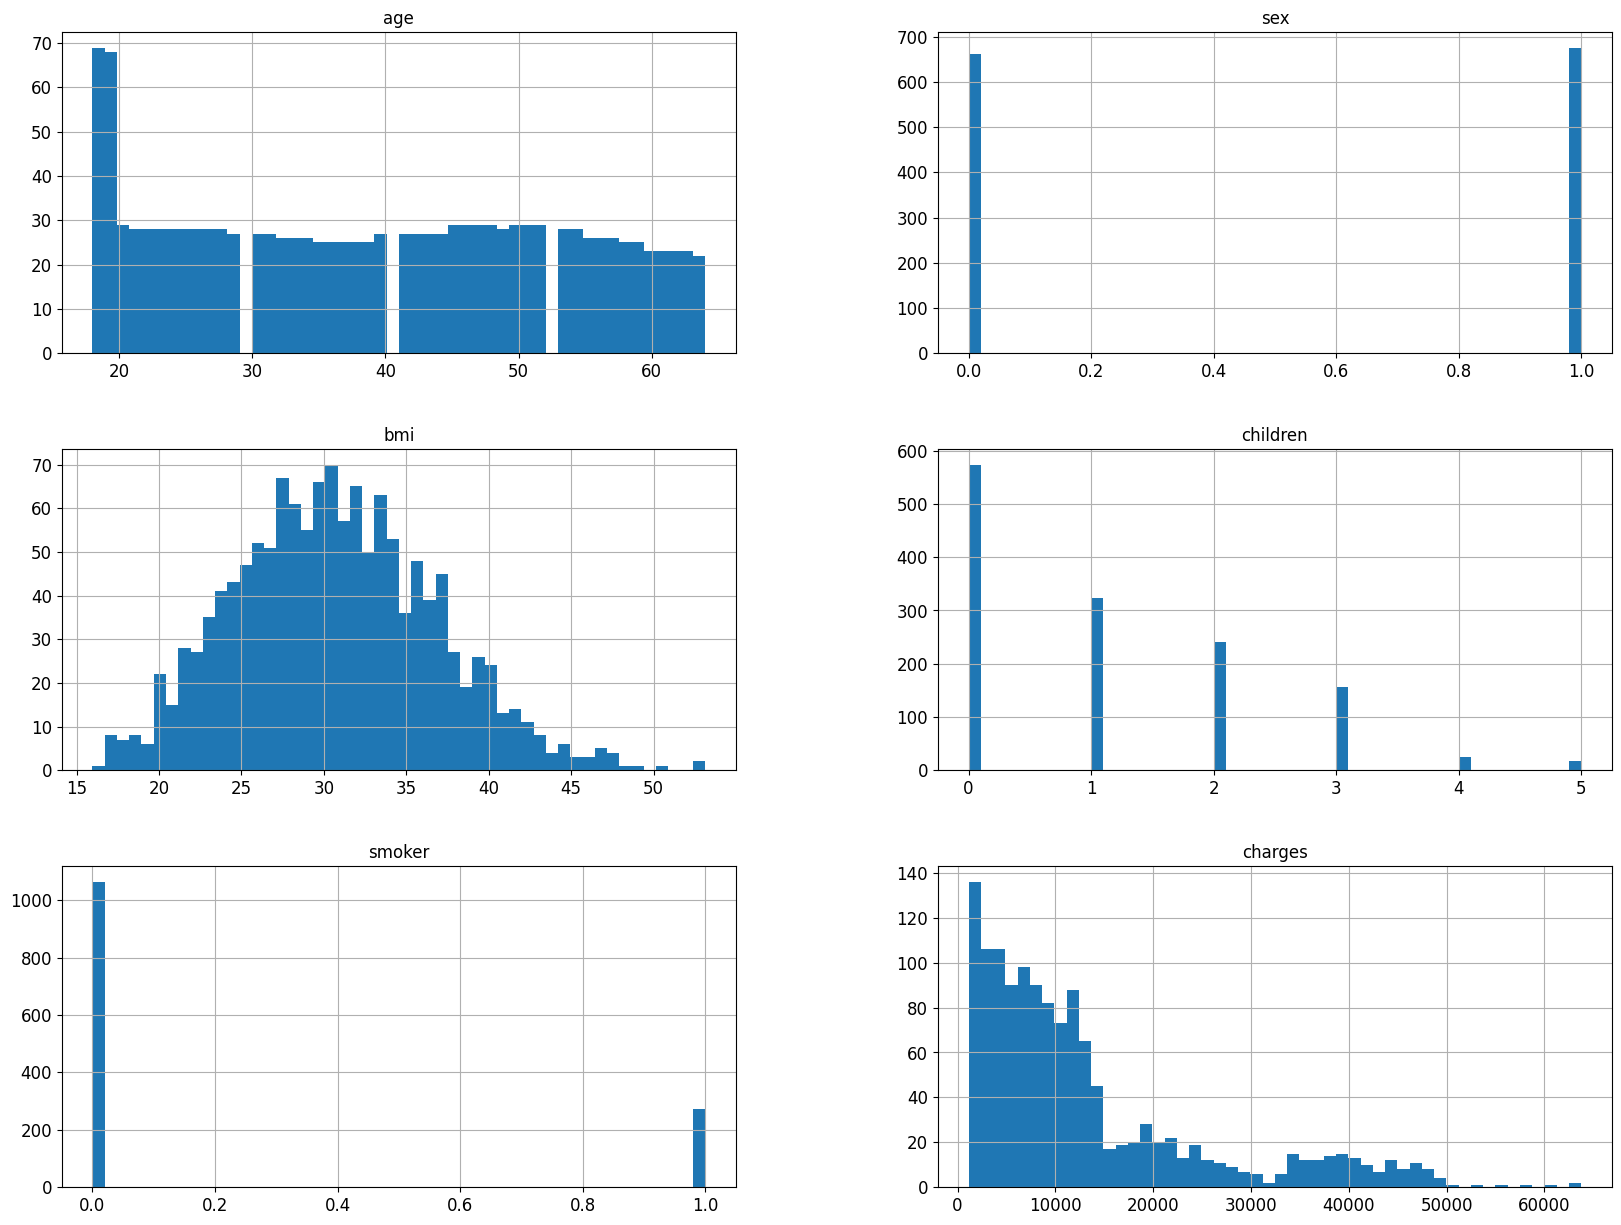

In [17]:
encoded_dataframe.hist(bins=50, figsize=(20,15))

In [18]:
dataframe.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [19]:
encoded_dataframe.head(2)

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.90,0,1,16884.9240,False,False,False,True
1,18,1,33.77,1,0,1725.5523,False,False,True,False


In [20]:
scaled_encoded_dataframe.head(2)

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,0.021739,0,0.321227,0.0,1,0.251611,False,False,False,True
1,0.000000,1,0.479150,0.2,0,0.009636,False,False,True,False


# Treinamento de Dados

Preparando dados de treinamento e de testes

In [21]:
X_e = encoded_dataframe.drop(columns=["charges"])

y_e = encoded_dataframe["charges"]

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)

print(len(X_train_e), "treinamento +", len(X_test_e), "teste")

1070 treinamento + 268 teste


In [22]:
X_se = scaled_encoded_dataframe.drop(columns=["charges"])

y_se = scaled_encoded_dataframe["charges"]

X_train_se, X_test_se, y_train_se, y_test_se = train_test_split(X_se, y_se, test_size=0.2, random_state=42)

print(len(X_train_se), "treinamento +", len(X_test_se), "teste")


1070 treinamento + 268 teste


In [23]:
# Configurando modelos
regressors = [
     ('SVR                    ', SVR(kernel='linear', C=4000.0))
    ,('Decision Tree Regressor', DecisionTreeRegressor(max_depth=33)) 
    ,('MLP Regressor          ', MLPRegressor(hidden_layer_sizes=(1000,), max_iter=2000))
    ,('Ridge                  ', Ridge(alpha=1.0))
    ,('Elastic Net            ', ElasticNet(alpha=0.01, l1_ratio=0.5))  
    ,('Linear Regression      ', LinearRegression())
    ,('Lasso                  ', Lasso(alpha=0.1))
    ,('Random Forest Regressor', RandomForestRegressor(n_estimators=30, random_state=42))    
]

In [24]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
  for name, model in models:
    # Registra o tempo de início
    begin = time.time()
    # Fit the classifier on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # 5. Avaliar o desempenho do modelo usando MAE, MSE, RMSE e R²
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, y_pred)

    # Calcula o tempo de execução
    duration = time.time() - begin

    # Print the accuracy for each classifier
    print(f'{name}: MAE = {mae:.3f} - MSE = {mse:.3f} - RMSE = {rmse:.3f} - R2 = {r2:.3f} [{duration:.3f}sec]')
  print('>>>>>>>>> Avaliado! <<<<<<<<<')

# Avaliando os resultados ✅

Vamos avaliar o modelo com as seguintes métricas:

O **RMSE** é a raiz quadrada do **MSE** *(Erro Quadrático Médio - Mean Squared Error)*. o **MSE** é a média dos quadrados das diferenças entre os valores reais e os valores previstos.

O **MAE** *(Erro Médio Absoluto - Mean Absolute Error)*, onde um valor pequeno para MAE significa que suas previsões estão próximas das reais.

O **"R-squared (R2)"** fornece informações sobre o ajuste geral do modelo. O valor do R2 pode variar entre 0 e 1, quanto mais próximo de 1, melhor, pois indica que o modelo explica uma maior proporção da variabilidade nos dados. O R2 é também uma das principais métricas de avaliação do modelo de regressão.

In [25]:
print('-----------------------------------------------------')
print('- Avaliando modelos lineares usando dados encodados -')
print('-----------------------------------------------------')
evaluate_models(regressors, X_train_e, X_test_e, y_train_e, y_test_e)

-----------------------------------------------------
- Avaliando modelos lineares usando dados encodados -
-----------------------------------------------------
SVR                    : MAE = 3160.101 - MSE = 42908822.655 - RMSE = 6550.483 - R2 = 0.724 [2.993sec]
Decision Tree Regressor: MAE = 3170.862 - MSE = 43715262.608 - RMSE = 6611.752 - R2 = 0.718 [0.033sec]
MLP Regressor          : MAE = 4185.692 - MSE = 34431116.898 - RMSE = 5867.803 - R2 = 0.778 [122.061sec]
Ridge                  : MAE = 4193.348 - MSE = 33642947.835 - RMSE = 5800.254 - R2 = 0.783 [0.019sec]
Elastic Net            : MAE = 4245.507 - MSE = 33901798.289 - RMSE = 5822.525 - R2 = 0.782 [0.014sec]
Linear Regression      : MAE = 4181.194 - MSE = 33596915.851 - RMSE = 5796.285 - R2 = 0.784 [0.021sec]
Lasso                  : MAE = 4181.247 - MSE = 33597180.375 - RMSE = 5796.307 - R2 = 0.784 [0.009sec]
Random Forest Regressor: MAE = 2554.978 - MSE = 21895561.620 - RMSE = 4679.269 - R2 = 0.859 [0.253sec]
>>>>>>>>> Av

In [26]:
print('-------------------------------------------------------------------')
print('- Avaliando modelos lineares usando dados encodados e escalonados -')
print('-------------------------------------------------------------------')
evaluate_models(regressors, X_train_se, X_test_se, y_train_se, y_test_se)

-------------------------------------------------------------------
- Avaliando modelos lineares usando dados encodados e escalonados -
-------------------------------------------------------------------
SVR                    : MAE = 0.076 - MSE = 0.009 - RMSE = 0.097 - R2 = 0.764 [32.461sec]
Decision Tree Regressor: MAE = 0.046 - MSE = 0.010 - RMSE = 0.098 - R2 = 0.759 [0.018sec]
MLP Regressor          : MAE = 0.045 - MSE = 0.006 - RMSE = 0.075 - R2 = 0.858 [2.906sec]
Ridge                  : MAE = 0.067 - MSE = 0.009 - RMSE = 0.093 - R2 = 0.783 [0.009sec]
Elastic Net            : MAE = 0.072 - MSE = 0.010 - RMSE = 0.102 - R2 = 0.735 [0.009sec]
Linear Regression      : MAE = 0.067 - MSE = 0.009 - RMSE = 0.092 - R2 = 0.784 [0.017sec]
Lasso                  : MAE = 0.153 - MSE = 0.040 - RMSE = 0.199 - R2 = -0.001 [0.010sec]
Random Forest Regressor: MAE = 0.041 - MSE = 0.006 - RMSE = 0.074 - R2 = 0.861 [0.252sec]
>>>>>>>>> Avaliado! <<<<<<<<<


O melhor modelo preditivo para o nosso conjunto de dados é o constuído pelo algoritmo __Random Forest Regressor__.

In [27]:
correlation_matrix = encoded_dataframe.corr().round(2)
print('Charges: ')
correlation_matrix["charges"].sort_values(ascending=False)

Charges: 


charges      1.00
smoker       0.79
age          0.30
bmi          0.20
children     0.07
southeast    0.07
sex          0.06
northeast    0.01
northwest   -0.04
southwest   -0.04
Name: charges, dtype: float64

A correlação de __bmi__ e os atributos _smoker_ (0.79), _age_ (0.30), _bmi_ (0.20), _children_ (0.07), _southeast_ (0.07) e _sex_ (0.06) é bem interessante. 

In [28]:
print('Smoker: ')
correlation_matrix["smoker"].sort_values(ascending=False)

Smoker: 


smoker       1.00
charges      0.79
sex          0.08
southeast    0.07
children     0.01
bmi          0.00
northeast    0.00
age         -0.03
northwest   -0.04
southwest   -0.04
Name: smoker, dtype: float64

A correlação de __smoker__ e os atributos _charges_ (0.79), _sex_ (0.08), e _southeast_ (0.07) é bem interessante. 

In [29]:
print('Age: ')
correlation_matrix["age"].sort_values(ascending=False)

Age: 


age          1.00
charges      0.30
bmi          0.11
children     0.04
southwest    0.01
northeast    0.00
northwest   -0.00
southeast   -0.01
sex         -0.02
smoker      -0.03
Name: age, dtype: float64

A correlação de __age__ e os atributos _charges_ (0.30) e _bmi_ (0.11) é bem interessante. 

In [ ]:
print('BMI: ')
correlation_matrix["bmi"].sort_values(ascending=False)

A correlação de __bmi__ e os atributos _southeast_ (0.27), _charges_ (0.20), _age_ (0.11) e _sex_ (0.02) é bem interessante. 

In [36]:
print('Children: ')
correlation_matrix["children"].sort_values(ascending=False)

Children: 


children     1.00
charges      0.07
age          0.04
sex          0.02
northwest    0.02
southwest    0.02
bmi          0.01
smoker       0.01
northeast   -0.02
southeast   -0.02
Name: children, dtype: float64

A correlação de __children__ e os demias atributos é muito baixa. Pode ser descartado do modelo de predição.

In [31]:
print('sex: ')
correlation_matrix["sex"].sort_values(ascending=False)

sex: 


sex          1.00
smoker       0.08
charges      0.06
bmi          0.05
children     0.02
southeast    0.02
northeast   -0.00
southwest   -0.00
northwest   -0.01
age         -0.02
Name: sex, dtype: float64

A correlação de __sex__ e os demias atributos é muito baixa. Pode ser descartado do modelo de predição.

In [32]:
print('Southeast: ')
correlation_matrix["southeast"].sort_values(ascending=False)

Southeast: 


southeast    1.00
bmi          0.27
smoker       0.07
charges      0.07
sex          0.02
age         -0.01
children    -0.02
northeast   -0.35
northwest   -0.35
southwest   -0.35
Name: southeast, dtype: float64

A correlação da região __southeast__ e o atributo _bmi_ (0.27) é bem interessante. Com os atributos _smoker_ (0.07) e 
_charges_ (0.07) tem um grau de relevancia baixo, mas maior do que 5%. 

Como as outras regiões não trazem relevância para as nossas predições, este atributo por também ser uma região, pode ser descartado de nosso modelo preditivo.

In [33]:
print('Northeast: ')
correlation_matrix["northeast"].sort_values(ascending=False)

Northeast: 


northeast    1.00
charges      0.01
age          0.00
sex         -0.00
smoker       0.00
children    -0.02
bmi         -0.14
northwest   -0.32
southwest   -0.32
southeast   -0.35
Name: northeast, dtype: float64

A correlação da região __northeast__ e os outros atributos é muito baixa indicando que __northeast__ pode ser desconsiderado no treinamento  um modelo preditivo.

In [34]:
print('Northwest: ')
correlation_matrix["northwest"].sort_values(ascending=False)

Northwest: 


northwest    1.00
children     0.02
age         -0.00
sex         -0.01
smoker      -0.04
charges     -0.04
bmi         -0.14
northeast   -0.32
southwest   -0.32
southeast   -0.35
Name: northwest, dtype: float64

A correlação da região __northwest__ e os outros atributos é muito baixa indicando que __northwest__ pode ser desconsiderado no treinamento de um modelo preditivo.

In [35]:
print('Southwest: ')
correlation_matrix["southwest"].sort_values(ascending=False)

Southwest: 


southwest    1.00
children     0.02
age          0.01
sex         -0.00
bmi         -0.01
smoker      -0.04
charges     -0.04
northeast   -0.32
northwest   -0.32
southeast   -0.35
Name: southwest, dtype: float64

A correlação da região __southwest__ e os outros atributos é muito baixa indicando que  __southwest__ pode ser desconsiderado no treinamento de um modelo preditivo.

Os melhores modelos preditivos a serem treinados dado o nosso conjunto de dados, em ordem, são estes:

__Charges__: 
smoker       0.79
age          0.30
bmi          0.20

__Smoker__: 
charges      0.79

__Age__: 
charges      0.30
bmi          0.11

__BMI__: 
charges      0.20
age          0.11

In [36]:
# para deixar todas as saídas com os mesmos valores obtidos na live.
import numpy as np
np.random.seed(42)
import os

# Para plots bonitinhos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Analisando Dados ...

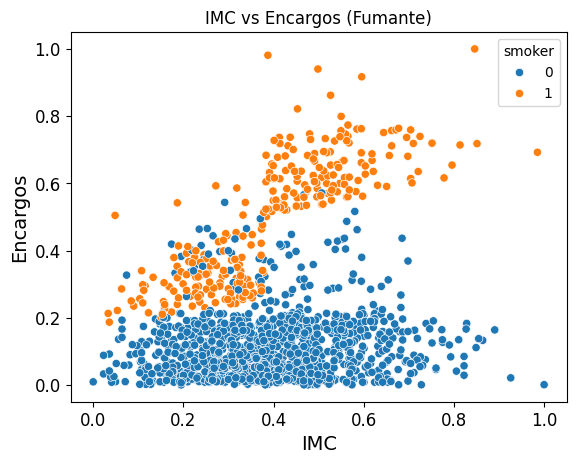

In [37]:
# Scatter plot de IMC vs Encargos
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=scaled_encoded_dataframe)
plt.title('IMC vs Encargos (Fumante)')
plt.xlabel('IMC')
plt.ylabel('Encargos')
plt.show()

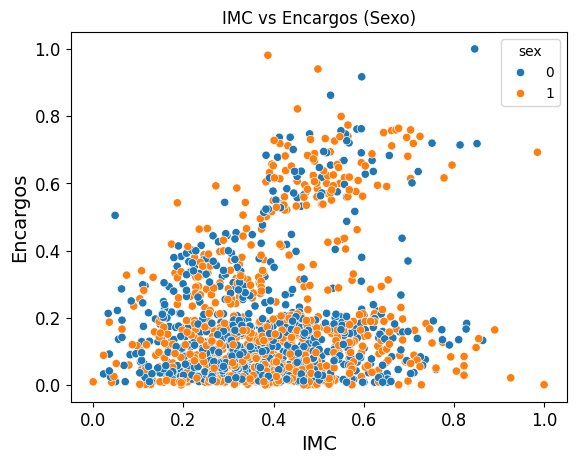

In [38]:
# Scatter plot de IMC vs Encargos
sns.scatterplot(x='bmi', y='charges', hue='sex', data=scaled_encoded_dataframe)
plt.title('IMC vs Encargos (Sexo)')
plt.xlabel('IMC')
plt.ylabel('Encargos')
plt.show()

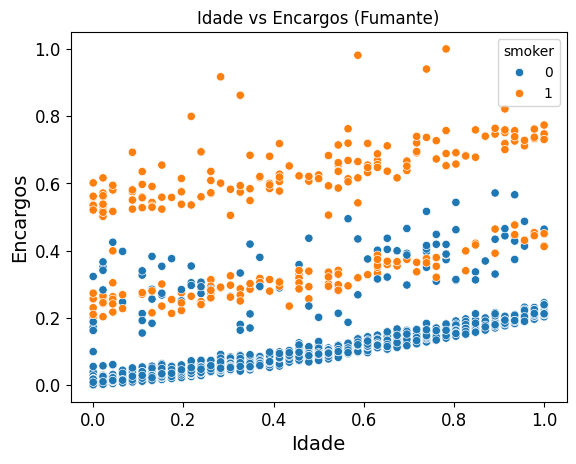

In [39]:
# Scatter plot de Fumante vs Encargos
sns.scatterplot(x='age', y='charges', hue='smoker', data=scaled_encoded_dataframe)
plt.title('Idade vs Encargos (Fumante)')
plt.xlabel('Idade')
plt.ylabel('Encargos')
plt.show()

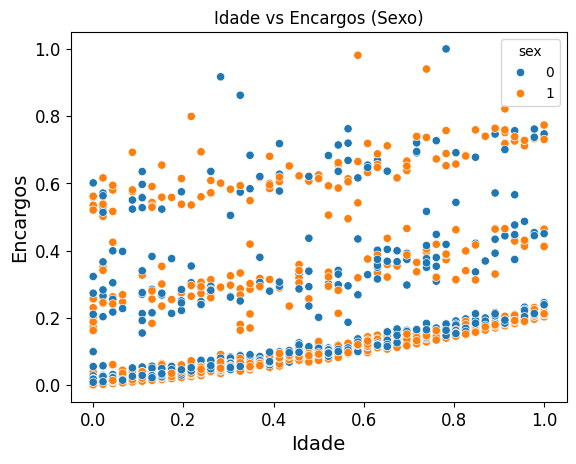

In [40]:
# Scatter plot de Fumante vs Encargos
sns.scatterplot(x='age', y='charges', hue='sex', data=scaled_encoded_dataframe)
plt.title('Idade vs Encargos (Sexo)')
plt.xlabel('Idade')
plt.ylabel('Encargos')
plt.show()

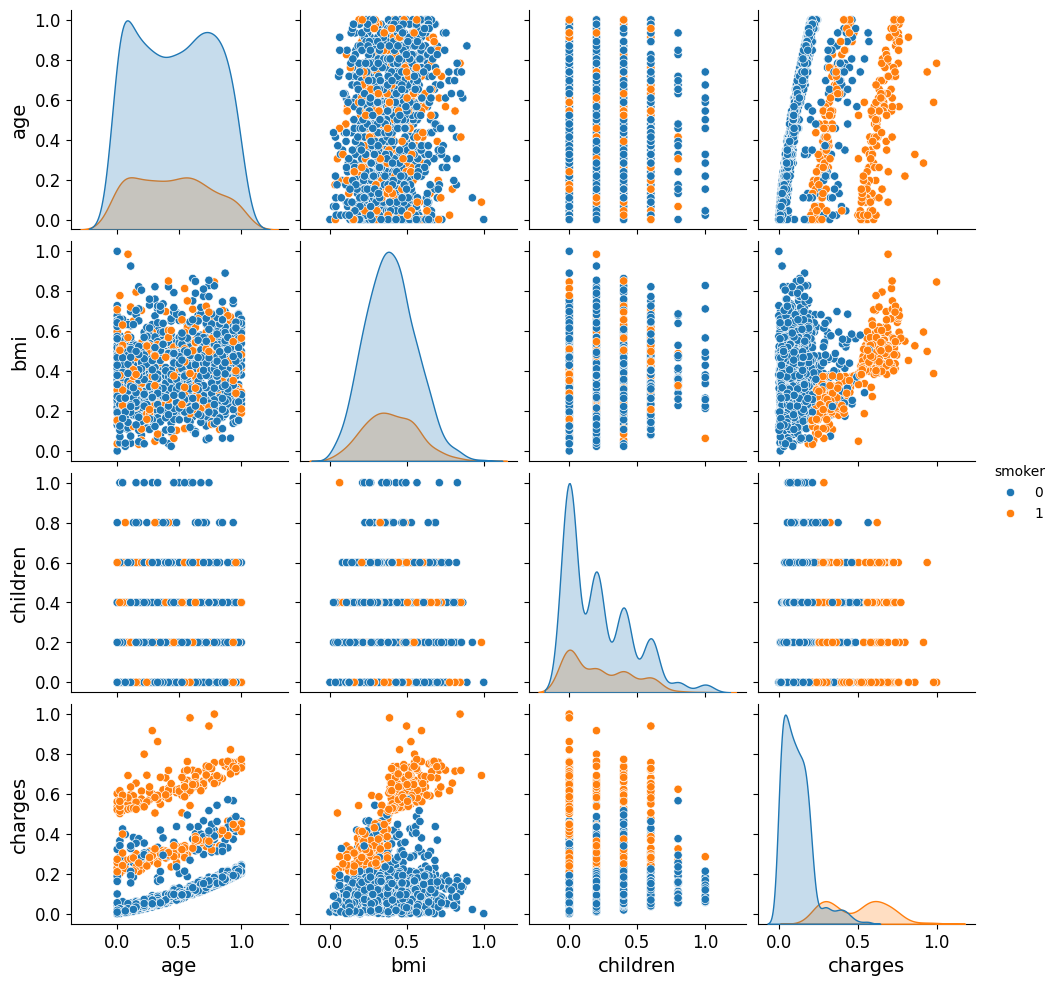

In [41]:
# Pair plot das variáveis numéricas
sns.pairplot(scaled_encoded_dataframe, vars=['age', 'bmi', 'children', 'charges'], hue='smoker')
plt.show()

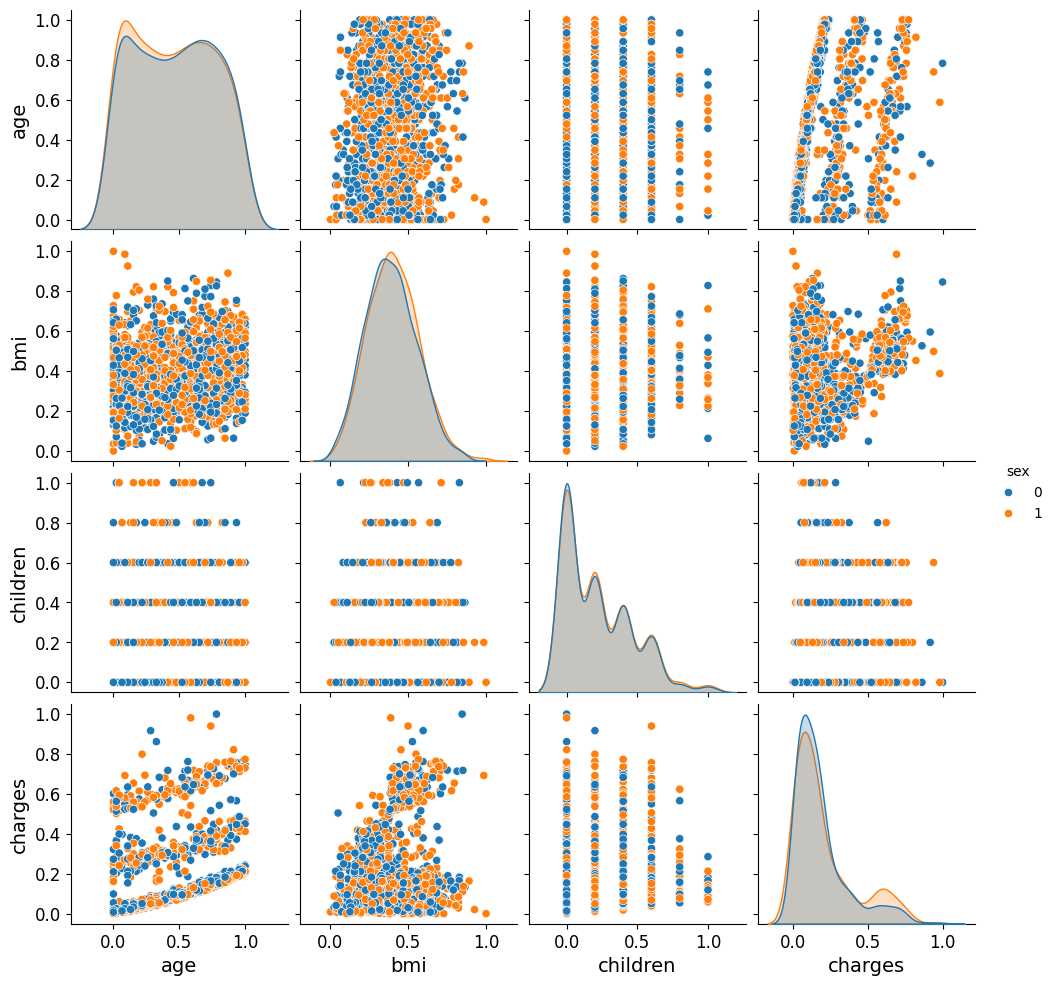

In [42]:
# Pair plot das variáveis numéricas
sns.pairplot(scaled_encoded_dataframe, vars=['age', 'bmi', 'children', 'charges'], hue='sex')
plt.show()

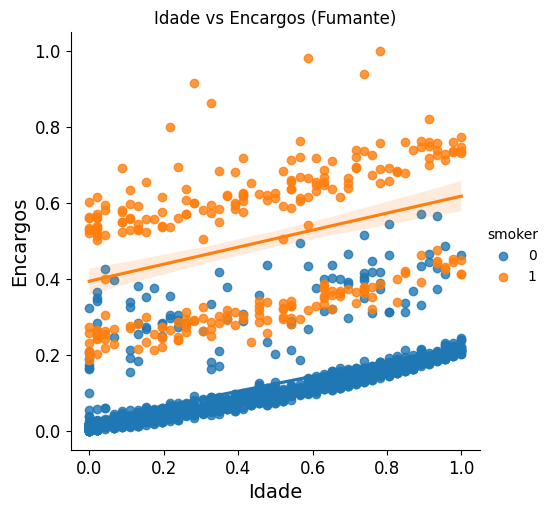

In [43]:
# Regressão linear de idade vs encargos
sns.lmplot(x='age', y='charges', hue='smoker', data=scaled_encoded_dataframe)
plt.title('Idade vs Encargos (Fumante)')
plt.xlabel('Idade')
plt.ylabel('Encargos')
plt.show()

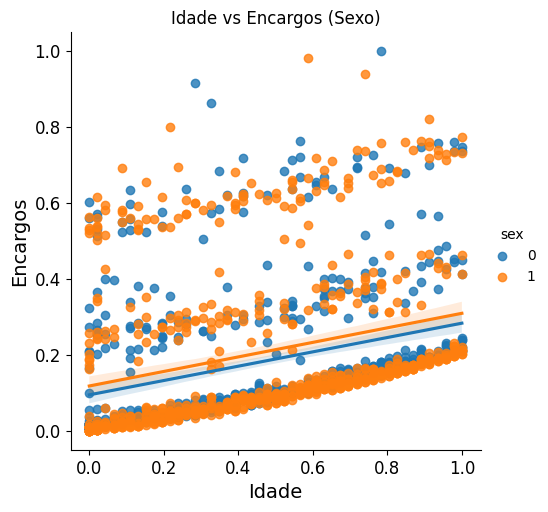

In [44]:
# Regressão linear de idade vs encargos
sns.lmplot(x='age', y='charges', hue='sex', data=scaled_encoded_dataframe)
plt.title('Idade vs Encargos (Sexo)')
plt.xlabel('Idade')
plt.ylabel('Encargos')
plt.show()

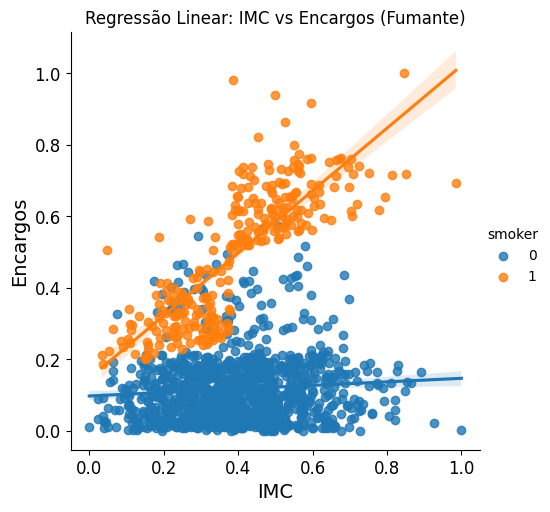

In [45]:
# Regressão linear de IMC vs encargos
sns.lmplot(x='bmi', y='charges', hue='smoker', data=scaled_encoded_dataframe)
plt.title('Regressão Linear: IMC vs Encargos (Fumante)')
plt.xlabel('IMC')
plt.ylabel('Encargos')
plt.show()

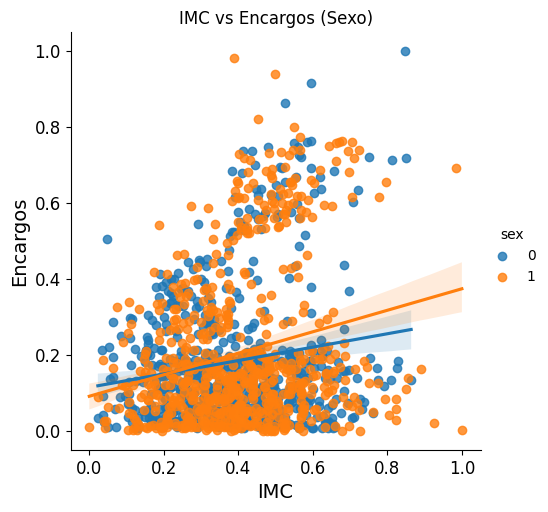

In [46]:
# Regressão linear de IMC vs encargos
sns.lmplot(x='bmi', y='charges', hue='sex', data=scaled_encoded_dataframe)
plt.title('IMC vs Encargos (Sexo)')
plt.xlabel('IMC')
plt.ylabel('Encargos')
plt.show()